# Problem Set 6: Unsupervised and Deep Learning

<span style="color:red">Warning!</span> Some of the problems in this problem set require heavy computation - you are encouraged to start early so that you don't get stuck at the last minute.

# Face Recognition

Your goal for this problem set is to design a basic face recognition system. Since the machine learning force is now strong with you, the prompts for this problem set are deliberately vague. Be creative - but be careful! It my be useful to start by implementing this entire problem set on a relatively small subset of all of the images first, before using the full dataset.

## 1. Data Preprocessing and  Exploration

Download the "[Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)" data set from [this link](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (roughly 250MB).

### 1.1. Filter out people with few images

First, display a histogram that shows the number of images per individual (you may use log-scale if you like). Which individual has the most images from your dataset? 

Now, remove all individuals for whom you have fewer than 10 images. How many individuals are you left with in the dataset?

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import sys
import warnings 
import sklearn
warnings.filterwarnings('ignore')

In [2]:
# Read the files. 
data_dir = 'lfw_funneled' 
data_list = os.listdir(data_dir)

names = [] 
paths = {}
numbers = []

for dataset in data_list: 
    if os.path.isdir(data_dir + '/' + dataset):
        img_list = os.listdir(data_dir + '/' + dataset) 
        names.append(dataset) 
        numbers.append(len(img_list)) 
        paths[dataset] = img_list
        
# Create a df to report the names and number of images and sort by number.
df = pd.DataFrame({'name': names, 'numbers': numbers, 'paths': paths.values()})
df = df.sort_values(by='numbers', ascending=False)
df.head()

,name,numbers,paths
4982,George_W_Bush,530,"[George_W_Bush_0387.jpg, George_W_Bush_0393.jp..."
3541,Colin_Powell,236,"[Colin_Powell_0195.jpg, Colin_Powell_0181.jpg,..."
1554,Tony_Blair,144,"[Tony_Blair_0002.jpg, Tony_Blair_0016.jpg, Ton..."
3014,Donald_Rumsfeld,121,"[Donald_Rumsfeld_0029.jpg, Donald_Rumsfeld_001..."
1392,Gerhard_Schroeder,109,"[Gerhard_Schroeder_0095.jpg, Gerhard_Schroeder..."


George_W_Bush has the most images. 

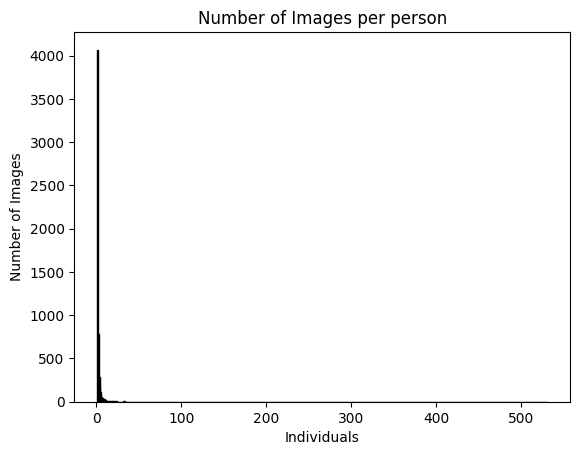

In [3]:
import matplotlib.pyplot as plt

# Create a histogram of the image counts
plt.hist(numbers, bins=range(min(numbers), max(numbers)+2), edgecolor='black')

plt.title('Number of Images per person')
plt.xlabel('Individuals')
plt.ylabel('Number of Images')

# Display the plot
plt.show()

In [4]:
# Remove all individuals that have fewer than 10 images.
df = df[df['numbers'] >= 10] 
len(df)

158

There are 158 individuals left. 

In [5]:
# Create a new dataframe reported image paths and labels.
paths = [] 
labels = [] 

for i in range(len(df)):
    for j in range(len(df['paths'].iloc[i])):
        paths.append(data_dir + '/' + df['name'].iloc[i] + '/' + df['paths'].iloc[i][j]) 
        labels.append(df['name'].iloc[i])
image_df = pd.DataFrame({'path': paths, 'label': labels}) 
image_df.head()

,path,label
0,lfw_funneled/George_W_Bush/George_W_Bush_0387.jpg,George_W_Bush
1,lfw_funneled/George_W_Bush/George_W_Bush_0393.jpg,George_W_Bush
2,lfw_funneled/George_W_Bush/George_W_Bush_0378.jpg,George_W_Bush
3,lfw_funneled/George_W_Bush/George_W_Bush_0422.jpg,George_W_Bush
4,lfw_funneled/George_W_Bush/George_W_Bush_0344.jpg,George_W_Bush


### 1.2. Show some faces!

1. Pick 10 random images from the dataset and display them in a 2 x 5 grid.
2. This time pick 200 random images. Create a single image that shows the "average face" over this random sample -- i.e. each pixel should display the average value of that particular pixel across the random sample. 

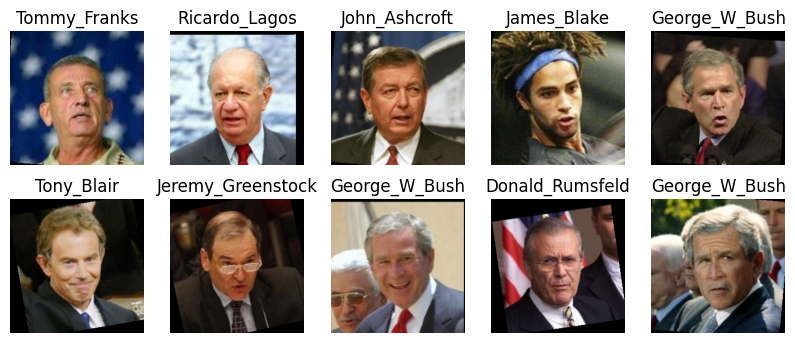

In [165]:
# Plot 10 random image
np.random.seed(251)
random10= image_df.sample(10)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        axes[i, j].imshow(plt.imread(random10['path'].iloc[i*5+j])) 
        axes[i, j].set_title(random10['label'].iloc[i*5+j])
        axes[i, j].axis('off')
plt.show()

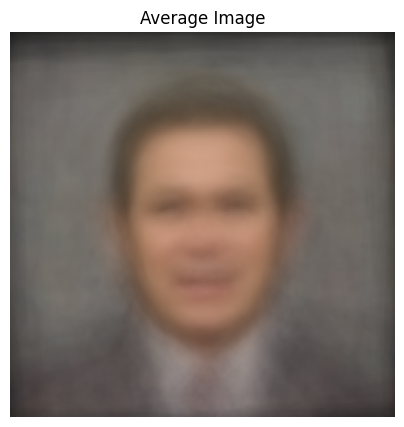

(200, 250, 250, 3)

In [12]:
# Sample 200 image paths and make an average image
random200 = image_df.sample(200)
image_pixel = [] 

for i in range(len(random200)):
    image_pixel.append(plt.imread(random200['path'].iloc[i])) 

image_pixel = np.array(image_pixel)
average_img = np.mean(image_pixel, axis=0)

plt.figure(figsize=(5, 5))
plt.imshow(average_img/255.0) 
plt.title('Average Image') 
plt.axis('off')
plt.show()
image_pixel.shape

## 2. k-Means Clustering

### 2.1. Implementation

Implement the k-Means clustering algorithm that we discussed in class, using the Euclidean distance function. Do not use a library like sklearn which provides you built-in k-Means modules. 

*Hint:* You may implement the algorithm using the following steps:
1. initialize the clusters randomly
2. assign each data point to the closest cluster
3. re-estimate cluster centers
4. repeat until assignment doesn't change

*Hint:* You may find  the [`pairwise_distances_argmin`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html) function useful for step 2.

In [6]:
import numpy as np
from sklearn.metrics import pairwise_distances_argmin
def k_means(X, k, max_iters=100, tol=1e-4, show_progress  = False):
    num_samples, num_features = X.shape
    
    # Step 1: Initialize clusters randomly
    centroids = X[np.random.choice(num_samples, k, replace=False)]
    
    for i in range(max_iters):
        if show_progress:
            if (i+1) % 10 == 0:
                print('Iteration %d/%d' % (i+1, max_iters))
        
        # Step 2: Assign each data point to the closest cluster
        labels = pairwise_distances_argmin(X, centroids, metric='euclidean')
        
        # Step 3: Re-estimate cluster centers
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])
        
        # Step 4: Check for convergence
        if np.allclose(centroids, new_centroids, atol=tol):
            break
        else:
            centroids = new_centroids
    
    return centroids, labels


### 2.2. Sanity check

Apply your k-Means algorithm to a toy dataset to make sure it works properly. Also create a scatterplot that shows these datapoints, colored by cluster. 

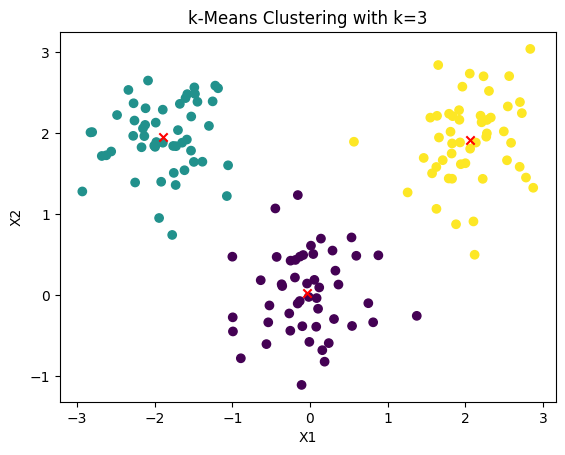

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a toy dataset with 3 clusters
X = np.concatenate([
    np.random.normal(loc=[0, 0], scale=0.5, size=(50, 2)),
    np.random.normal(loc=[2, 2], scale=0.5, size=(50, 2)),
    np.random.normal(loc=[-2, 2], scale=0.5, size=(50, 2))
])

# Run k-means clustering with k=3
centroids, labels = k_means(X, k=3)

# Create a scatterplot of the data points colored by cluster
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', marker='x')
plt.title("k-Means Clustering with k=3")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


### 2.3. Image centroids
Apply your k-Means algorithm to the images dataset, using k=10. 

__Make sure to standardize your data first!__ (You can use sklearn's `Standard Scaler`). You may also want to divide the RGB values by 255.

 Show a 10 x 2 grid of images where the first column contains (a) the image that represents the centroid for each of those clusters, and the second column contains (b) the closest image in the original dataset to that centroid. Use Euclidean distance. What do you notice?

*Note:* As you may notice, there are 250x250x3 = 187500 features for each image. If your k-Means algorithm is not implemented efficiently -- and even if it is -- it might take a long time for your algorithm to converge. If your computer is slow, it might even take a very long time for you to simply standardize your data. If your algorithm is slow, we recommend you convert your RGB images into grayscale first (using, for instance, the [`rgb2grey`](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey) function, or any other way to convert to graysacle) before standardizing. You may also choose to do this part using RGB images.



In [8]:
# Convert RGB images into grayscale and read them. 

from skimage.color import rgb2gray
image_pixel = []

for i in range(len(image_df)):
    image_pixel.append(rgb2gray(plt.imread(image_df['path'].iloc[i])) )

In [10]:
# Standardize the data and turn images into 1d
image_pixel = np.array(image_pixel)
image_pixel = image_pixel.reshape(4324, -1)
from sklearn.preprocessing import StandardScaler
image_pixel_scaled = StandardScaler().fit_transform(image_pixel)

In [26]:
# Apply k-means function
np.random.seed(251)
centroids, labels = k_means(image_pixel_scaled, k=10, max_iters=100, tol=1e-4, show_progress=True)

Iteration 10/100
Iteration 20/100
Iteration 30/100


In [29]:
# Transform the centroids back to the original scale
centroids_normed = StandardScaler().inverse_transform(centroids)
centroids_all = [] 
for i in range(10):
    centroids_all.append(centroids_normed[i].reshape(250, 250, 1))

In [30]:
# Find the cloest image.
from sklearn.metrics import pairwise_distances_argmin
closest_idx = [] 

for i in range(10):
    distances = pairwise_distances(all_image_pixel_values_scaled, [centroids[i]], metric='euclidean') 
    closest_idx.append(np.argsort(distances.ravel())[0])
    
closest_images = [] 
for i in range(10):
    closest_images.append(all_image_pixel_values[closest_idx[i]].reshape(250, 250, 1))

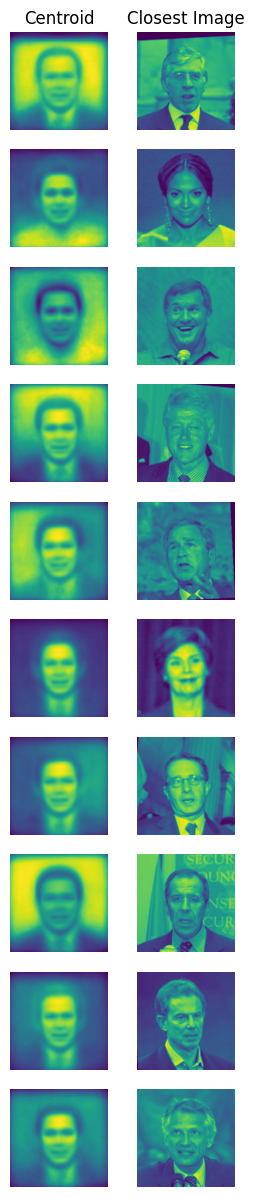

In [33]:
# Plot the result.
fig, ax = plt.subplots(10, 2, figsize=(5, 15)) 
for i in range(10):
    # add subtitles to the top row
    if i == 0:
        ax[i, 0].set_title('Centroid Image') 
        ax[i, 1].set_title('Closest Image')
    ax[i, 0].imshow(centroids_all[i]) 
    ax[i, 0].axis('off')
    ax[i, 1].imshow(closest_images[i]) 
    ax[i, 1].axis('off')
plt.show()

It focus more on outlines rather than facial organs. 

### 2.4 Classify yourself

Take a picture of yourself and scale it so that it is in a similar format to the images in the dataset. Show four images:
 1. The image of yourself.
 2. The cluster centroid closest to that image.
 3. The closest image in the dataset to that cluster centroid.
 4. The closest image in the dataset to the image of yourself.


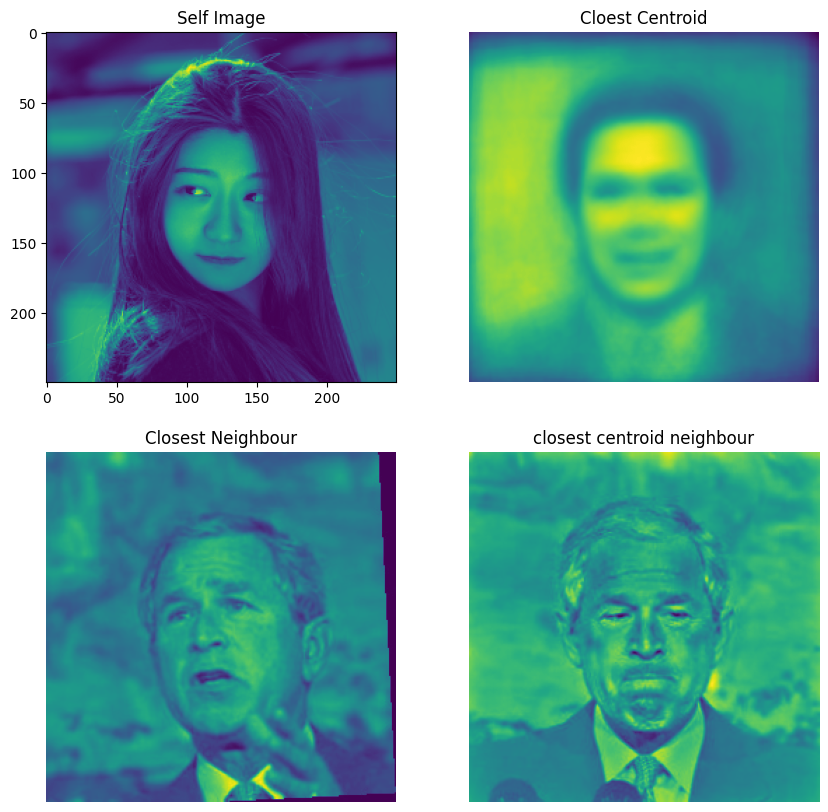

In [181]:
# My Image
from skimage.transform import resize
from sklearn.metrics import pairwise_distances_argmin
gina = plt.imread('ginawsy.jpg')
gina = resize(gina,(250,250,1))
gina = gina.reshape((1, 250*250*1))

# Closest Centroid
closest_centroid = pairwise_distances_argmin(gina, centroids, metric='euclidean') 

# Closest Image
closest_neig = pairwise_distances_argmin(gina, all_image_pixel_values_scaled, metric='euclidean') 

# Plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()

ax[0].imshow(gina.reshape(250,250,1))
ax[0].set_title('Self Image')

ax[1].imshow(centroids_all[closest_centroid[0]].reshape(250,250,1))
ax[1].axis('off')
ax[1].set_title('Cloest Centroid') 

ax[2].imshow(closest_images[closest_centroid[0]].reshape(250,250,1))
ax[2].axis('off')
ax[2].set_title('Closest Neighbour') 

ax[3].imshow(all_image_pixel_values_scaled[closest_neig[0]].reshape(250, 250, 1)) 
ax[3].axis('off')
ax[3].set_title('closest centroid neighbour')
plt.show()

Oh, it does not look like me.... It seems to focus on body posture more than facial expression.

# 3. Deep Learning

*Note:* You may use either `keras` or `PyTorch` to define your neural networks.

### 3.1 Data preprocessing
1. For this problem, filter to images associated with people that have at least 100 images in the dataset. Use the color version of the images (not grayscale). We'll use this dataset for a supervised multiclass classification problem, classifying which person each image is. How many classes (people) are there? How many observations (images) are there total?

2. Divide the reduced dataset into 50% train and 50% test. Standardize the data.

In [10]:
# Fill people who has more than 100 images
data = df[df['numbers']>=100]

paths = []
labels = []

for i in range(len(data)):
 for j in range(len(df['paths'].iloc[i])):
     paths.append(data_dir + '/' + data['name'].iloc[i] + '/' + data['paths'].iloc[i][j])
     labels.append(data['name'].iloc[i])
image_df = pd.DataFrame({'path': paths, 'label': labels})
image_df['label'].unique()

array(['George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld',
       'Gerhard_Schroeder'], dtype=object)

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
dicts = {'George_W_Bush':0,
        'Colin_Powell':1,
        'Tony_Blair':2,
        'Donald_Rumsfeld':3,
        'Gerhard_Schroeder':4}
label_num = [dicts[label] for label in image_df['label']]
label_num = to_categorical(label_num)


image_data = []
for i in range(len(image_df)):
  image_data.append(plt.imread(image_df['path'].iloc[i]))
image_data = np.array(image_data)
image_data.shape


2023-04-24 23:38:27.993133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Train test split
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(image_data, label_num, test_size=0.5, random_state=1)

In [13]:
# Standardize the data to 0-1 range
train_data = train_data/255
test_data = test_data/255

There are 5 people and 1140 observations.

### 3.2 Naive baseline
As a naive baseline method to compare to, create a random ordering of the labels in the training set and the test set. Report the overall classification accuracy for the shuffled labels in comparison to the true labels. Also report the true positive rate for each class. This random baseline represents a naive classifier that guesses randomly among the classes. What do you notice about the differences in precision and recall across classes?

In [337]:
# Random predictions by suffling the labels
import random
train_pred = train_labels.copy()
random.shuffle(train_pred)
test_pred = test_labels.copy()
random.shuffle(test_pred)


In [323]:
# Overall accuracy
from sklearn.metrics import accuracy_score
print('Train Accuracy:', accuracy_score(train_labels, train_pred))
print('Test Accuracy:', accuracy_score(test_labels, test_pred))

Train Accuracy: 0.33157894736842103
Test Accuracy: 0.3526315789473684


In [324]:
# TPR for each class
from sklearn.metrics import recall_score
print('Train recall_score:', recall_score(train_labels, train_pred, average=None))
print('Test recall_score:', recall_score(test_labels, test_pred, average=None))

Train TPR: [0.50187266 0.23770492 0.1971831  0.09433962 0.12280702]
Test TPR: [0.51711027 0.34210526 0.17808219 0.13235294 0.07692308]


In [325]:
# Precision for each class
from sklearn.metrics import precision_score
print('Train Precision:', precision_score(train_labels, train_pred, average=None))
print('Test Precision:', precision_score(test_labels, test_pred, average=None))

Train FPR: [0.48550725 0.22307692 0.21538462 0.0862069  0.17073171]
Test FPR: [0.50557621 0.2826087  0.1969697  0.16071429 0.09756098]


Since there are the precision and recall vary across classes, it indicates the class imbalance and the random shuffling of the labels. For Bush and Powell have higher precision and recall across classes and have higher number of samples. 

### 3.3 Feed forward neural network
Reshape your X data so that each observation is flattened into a 1d array, and each of the training and test matrices are 2d arrays. The shape of your data should be n_observations X 187,500. Train a fully connected neural network to predict which class each observation is in. The input_dimensions of your network will be 187,500 for each of the 187,500 "features" obtained from the flattened images. You are responsible for determining the structure of the network, the activiation functions, regularization, and optmization techniques. Ensure that your network exceeds 70% overall classification accuracy on the test set. Report the classification accuracy on the test set, along with the precision and recall for each class. What do you notice about the precision and recall values, as well as the overall classification accuracy, in comparison to the naive baseline?

*Hint: If you're not sure where to start, consider revisiting the lab notebooks on Neural Networks.*

In [15]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((570, 250, 250, 3), (570, 5), (570, 250, 250, 3), (570, 5))

In [16]:
# Reshape the data
train_data_scaled = train_data.reshape(570, -1)
test_data_scaled = test_data.reshape(570, -1)

In [21]:
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import classification_report

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=187500))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data_scaled, train_labels, validation_data=(test_data_scaled, test_labels), epochs=50, batch_size=10)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data_scaled,test_labels)
print("test loss:", test_loss)
print("test accuracy:", test_acc)
# Make predictions on the test set
y_pred = model.predict(test_data_scaled)
y_pred = np.argmax(y_pred, axis=1)

Epoch 1/50
57/57 [==============================] - 67s 1s/step - loss: 22.6191 - accuracy: 0.3456 - val_loss: 5.8120 - val_accuracy: 0.4789
Epoch 2/50
57/57 [==============================] - 57s 959ms/step - loss: 4.6417 - accuracy: 0.4789 - val_loss: 4.1580 - val_accuracy: 0.4842
Epoch 3/50
57/57 [==============================] - 55s 953ms/step - loss: 1.9062 - accuracy: 0.5772 - val_loss: 1.3877 - val_accuracy: 0.5474
Epoch 4/50
57/57 [==============================] - 65s 1s/step - loss: 1.4028 - accuracy: 0.6386 - val_loss: 3.0362 - val_accuracy: 0.3649
Epoch 5/50
57/57 [==============================] - 54s 946ms/step - loss: 2.5751 - accuracy: 0.5491 - val_loss: 1.9599 - val_accuracy: 0.4491
Epoch 6/50
57/57 [==============================] - 53s 926ms/step - loss: 0.8812 - accuracy: 0.7193 - val_loss: 1.5297 - val_accuracy: 0.5158
Epoch 7/50
57/57 [==============================] - 54s 944ms/step - loss: 0.9422 - accuracy: 0.7263 - val_loss: 1.3291 - val_accuracy: 0.6281
Epoc

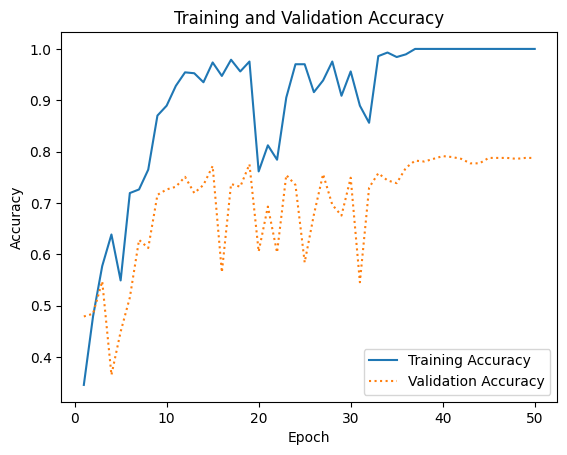

In [26]:
def show_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()
    
show_history(history)

18/18 [==============================] - 1s 63ms/step


Text(113.78159722222219, 0.5, 'Actual label')

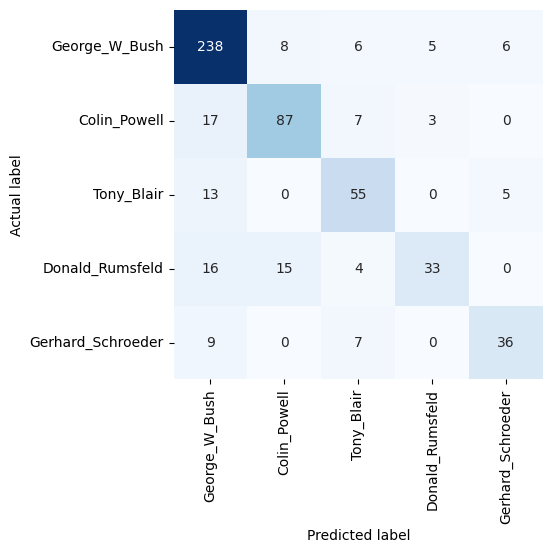

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_predicted = model.predict()
mat = confusion_matrix(test_labels.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=image_df['label'].unique(),
            yticklabels=image_df['label'].unique())

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

It has better accuracy and perform better than naive. 

### 3.4 Convolutional neural network

Now, train a convolutional neural network to predict which person is in each image. As above, you are in charge of all design parameters for the network, including convolutional filters, pooling layers, regularization, and optimization. Ensure that your CNN achieves over 80% overall classification accuracy on the test set. Report the classification accuracy on the test set, along with the precision and recall for each class. What do you notice about the precision and recall values, as well as the overall classification accuracy, in comparison to the feed forward neural network and naive baseline?

*Hint: If you're not sure where to start, consider revisiting the lab notebooks on Neural Networks.*

In [19]:
# Random seeds
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import classification_report
import random
import tensorflow as tf
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D
from keras.constraints import maxnorm
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3),activation='linear',padding='valid',input_shape=(250,250,3)))

model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))

model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax')) 

model.compile(optimizer='Adamax',loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=10, batch_size=32)

Epoch 1/10
18/18 [==============================] - 31s 2s/step - loss: 1.2949 - accuracy: 0.5105 - val_loss: 1.3135 - val_accuracy: 0.5193
Epoch 2/10
18/18 [==============================] - 50s 3s/step - loss: 1.1997 - accuracy: 0.5298 - val_loss: 1.3328 - val_accuracy: 0.5316
Epoch 3/10
 6/18 [=========>....................] - ETA: 1:21 - loss: 1.0639 - accuracy: 0.5833

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data_scaled,test_labels)
print("test loss:", test_loss)
print("test accuracy:", test_acc)
# Make predictions on the test set
y_pred = model.predict(test_data_scaled)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_predicted = model.predict()
mat = confusion_matrix(test_labels.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=image_df['label'].unique(),
            yticklabels=image_df['label'].unique())

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

It performs the best compared to naive and nn. 